In [1]:

%pprint

Pretty printing has been turned OFF


In [2]:

import sys

# Insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../py')

In [3]:

%%time
import pandas as pd
import numpy as np

from storage import Storage
s = Storage()

from ha_utils import HeaderAnalysis
ha = HeaderAnalysis(s=s, verbose=False)

from scrape_utils import WebScrapingUtilities
wsu = WebScrapingUtilities()
uri = wsu.secrets_json['neo4j']['connect_url']
user =  wsu.secrets_json['neo4j']['username']
password = wsu.secrets_json['neo4j']['password']

from cypher_utils import CypherUtilities
cu = CypherUtilities(uri=uri, user=user, password=password, driver=None, s=s, ha=ha)

from section_utils import SectionUtilities
su = SectionUtilities(s=s, ha=ha, cu=cu, verbose=False)

from lr_utils import LrUtilities
from hc_utils import HeaderCategories

hc = HeaderCategories(cu=cu, verbose=False)
lru = LrUtilities(ha=ha, cu=cu, hc=hc, verbose=False)
lru.build_isheader_logistic_regression_elements()
lru.build_pos_logistic_regression_elements()

from crf_utils import CrfUtilities
crf = CrfUtilities(ha=ha, hc=hc, cu=cu, verbose=False)

import warnings
warnings.filterwarnings('ignore')

CPU times: total: 3min 15s
Wall time: 3min 20s


In [4]:

navigable_parent_cypher_str = '''
    MATCH (np:NavigableParents {{navigable_parent: '{}'}})
    RETURN
        np.navigable_parent AS navigable_parent,
        np.is_header AS is_header,
        np.is_task_scope AS is_task_scope,
        np.is_minimum_qualification AS is_minimum_qualification,
        np.is_preferred_qualification AS is_preferred_qualification,
        np.is_legal_notification AS is_legal_notification,
        np.is_job_title AS is_job_title,
        np.is_office_location AS is_office_location,
        np.is_job_duration AS is_job_duration,
        np.is_supplemental_pay AS is_supplemental_pay,
        np.is_educational_requirement AS is_educational_requirement,
        np.is_interview_procedure AS is_interview_procedure,
        np.is_corporate_scope AS is_corporate_scope,
        np.is_posting_date AS is_posting_date,
        np.is_other AS is_other;'''

In [5]:

def get_quals_str(prediction_list, quals_list, basic_quals_dict):
    qual_count = 0
    quals_str = ''
    for pred_array, (i, qual_str) in zip(prediction_list, enumerate(quals_list)):
        if qual_str in basic_quals_dict:
            formatted_str = '\nquals_list[{}] = "{}" ({})'
        else:
            formatted_str = '\n*quals_list[{}] = "{}" ({})'
        prediction = pred_array[1]
        quals_str += formatted_str.format(i, qual_str, prediction)
        if prediction > 0.5:
            qual_count += 1
    
    return quals_str, qual_count

In [6]:

def qual_sum(qual_str):
    results = '"{}"'.format(qual_str)
    if qual_str in basic_quals_dict:
        results = basic_quals_dict[qual_str]
    else:
        results = predict_job_hunt_percent_fit([qual_str])[0][1]
        if results > 0.5:
            results = 1.0
        else:
            results = 0.0
    
    return str(results)

In [7]:

def print_loc_computation(row_index, quals_list, basic_quals_dict):
    print()
    numerator_str_list = []
    for qual_str in quals_list:
        if qual_str in basic_quals_dict:
            numerator_str_list.append(str(basic_quals_dict[qual_str]))
        else:
            numerator_str_list.append('000')
    numerator_str = '+'.join(numerator_str_list)
    print("hunting_df.loc[{}, 'percent_fit'] = ({})/{}".format(row_index, numerator_str, len(quals_list)))

In [8]:

import re

def print_fit_job(row_index, row_series, basic_quals_dict):
    job_fitness = 0.0
    file_name = row_series.file_name
    child_strs_list = ha.get_child_strs_from_file(file_name=file_name)
    indices_list = su.find_basic_quals_section_indexes(child_strs_list=child_strs_list, file_name=file_name)
    assert indices_list, f'Something is wrong with {file_name}'
    prequals_list = [child_str for i, child_str in enumerate(child_strs_list) if i in indices_list]
    sentence_regex = re.compile(r'[\.;]')
    quals_set = set()
    for qual in prequals_list:
        concatonated_quals_list = sentence_regex.split(qual)
        if len(concatonated_quals_list) > 2:
            for q in concatonated_quals_list:
                quals_set.add(q)
        else:
            quals_set.add(qual)
    quals_list = list(quals_set)
    prediction_list = list(predict_job_hunt_percent_fit(quals_list))
    quals_str, qual_count = get_quals_str(prediction_list, quals_list, basic_quals_dict)
    if len(prediction_list):
        job_fitness = qual_count/len(prediction_list)
        if job_fitness > 0.8:
            job_title = re.sub(r'(_-_Indeed.com)?(_[a-z0-9]{16})?\.html$', '', file_name).replace('_', ' ')
            print(f'Basic Qualifications for {job_title}:{quals_str}')
            print(job_fitness)
            print_loc_computation(row_index, quals_list, basic_quals_dict)
    
    return quals_list, job_fitness

In [9]:

def update_hunting(hunting_df, row_index, row_series, qual_sum, quals_list):
    percent_fit = eval(' + '.join(map(qual_sum, quals_list))) / len(quals_list)
    hunting_df.loc[row_index, 'percent_fit'] = percent_fit
    s.store_objects(hunting_df=hunting_df, verbose=False)
    file_name = cu.clean_text(row_series.file_name)
    cypher_str = f'''
        MATCH (fn:FileNames {{file_name: "{file_name}"}})
        SET fn.percent_fit = {percent_fit};'''
    print(cypher_str.strip())
    with cu.driver.session() as session:
        session.write_transaction(cu.do_cypher_tx, cypher_str)


---
# Training

In [377]:

cypher_str = '''
    MATCH (fn:FileNames)
    RETURN fn;'''
row_objs_list = cu.get_execution_results(cypher_str, verbose=False)
hunting_df = pd.DataFrame([{k: v for k, v in row_obj['fn'].items()} for row_obj in row_objs_list])

In [378]:

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Rebuild the dataframe from the dictionary
basic_quals_dict = s.load_object('basic_quals_dict')
rows_list = [{'qualification_str': qualification_str, 'is_fit': is_fit} for qualification_str, is_fit in basic_quals_dict.items()]
basic_quals_df = pd.DataFrame(rows_list)
print(basic_quals_df.shape)
mask_series = (basic_quals_df.is_fit == True)
basic_quals_df.loc[mask_series, 'is_fit'] = 1
mask_series = (basic_quals_df.is_fit == False)
basic_quals_df.loc[mask_series, 'is_fit'] = 0
s.store_objects(basic_quals_dict=basic_quals_df.set_index('qualification_str').is_fit.to_dict())
s.store_objects(basic_quals_df=basic_quals_df)

# Re-transform the bag-of-words and tf-idf from the new manual scores
sents_list = basic_quals_df.qualification_str.tolist()

# Bag-of-words
cv = CountVectorizer(lowercase=True, tokenizer=ha.html_regex_tokenizer, ngram_range=(1, 3))

# Learn the vocabulary dictionary and return the document-term matrix
bow_matrix = cv.fit_transform(sents_list)

s.store_objects(bq_cv_vocab=cv.vocabulary_)

# Tf-idf, must get from BOW first
tt = TfidfTransformer()
tfidf_matrix = tt.fit_transform(bow_matrix)
s.store_objects(bq_tt=tt)

# Re-train the classifier
X = tfidf_matrix.toarray()
y = basic_quals_df.is_fit.to_numpy().astype(int)
fit_estimators_dict = s.load_object('fit_estimators_dict')
basic_quals_clf = fit_estimators_dict['LogisticRegression']
basic_quals_clf.fit(X, y)
s.store_objects(basic_quals_clf=basic_quals_clf)

# Re-calibrate the inference engine
bq_cv_vocab = s.load_object('bq_cv_vocab')
bq_cv = CountVectorizer(vocabulary=bq_cv_vocab)
bq_cv._validate_vocabulary()
bq_tt = s.load_object('bq_tt')
def predict_job_hunt_percent_fit(quals_list):
    y_predict_proba = np.array([])
    if len(quals_list):
        X_test = bq_tt.transform(bq_cv.transform(quals_list)).toarray()
        y_predict_proba = basic_quals_clf.predict_proba(X_test)
    
    return y_predict_proba
print('Retraining complete')

(2195, 2)
Pickling to C:\Users\daveb\OneDrive\Documents\GitHub\job-hunting\saves\pkl\basic_quals_dict.pkl
Pickling to C:\Users\daveb\OneDrive\Documents\GitHub\job-hunting\saves\pkl\basic_quals_df.pkl
Pickling to C:\Users\daveb\OneDrive\Documents\GitHub\job-hunting\saves\pkl\bq_cv_vocab.pkl
Pickling to C:\Users\daveb\OneDrive\Documents\GitHub\job-hunting\saves\pkl\bq_tt.pkl
Pickling to C:\Users\daveb\OneDrive\Documents\GitHub\job-hunting\saves\pkl\basic_quals_clf.pkl
Retraining complete



----
# Inference

In [379]:

# Loop through all the unset %fit values, set them if you can, break for help if you can't
mask_series = (hunting_df.percent_fit >= 0.0)
for row_index, row_series in hunting_df[~mask_series].iterrows():
    quals_list, job_fitness = print_fit_job(row_index, row_series, basic_quals_dict)
    if job_fitness > 0.8:
        if all(qual_str in basic_quals_dict for qual_str in quals_list):
            update_hunting(hunting_df, row_index, row_series, qual_sum, quals_list)
        else:
            break
    elif len(quals_list):
        update_hunting(hunting_df, row_index, row_series, qual_sum, quals_list)
print('{}/{} = {}% completed'.format(hunting_df[mask_series].shape[0], hunting_df.shape[0],
                                     int(100 * hunting_df[mask_series].shape[0] / hunting_df.shape[0])))

MATCH (fn:FileNames {file_name: "Senior_Data_Scientist_-_Santa_Clara,_CA_-_Indeed.com_c267f29f0f85e8b8.html"})
        SET fn.percent_fit = 0.4;
755/756 = 99% completed


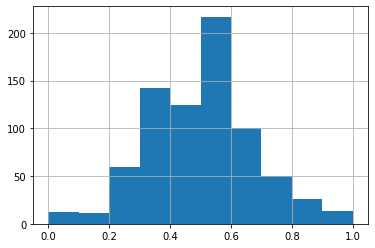

In [380]:

hunting_df.percent_fit.hist();

In [ ]:

# 754/756 = 99% completed
raise

In [ ]:

# Manually label the unscored qual
qualification_str = quals_list[1]
print(qualification_str)
basic_quals_dict = s.load_object('basic_quals_dict')
basic_quals_dict[qualification_str] = 1
s.store_objects(basic_quals_dict=basic_quals_dict)


----

In [ ]:

file_name = row_series.file_name
# file_name = 'Senior_Data_Scientist Statistics_and_Machine_Learning_b7c10bcd03f70654.html'
print(file_name)
child_strs_list = ha.get_child_strs_from_file(file_name=file_name)
cu.ensure_filename(file_name, verbose=False)
cu.populate_from_child_strings(child_strs_list, file_name, verbose=False)

In [ ]:

child_tags_list = ha.get_child_tags_list(child_strs_list)
print(child_tags_list)

In [ ]:

is_header_list = []
for is_header, child_str in zip(ha.get_is_header_list(child_strs_list), child_strs_list):
    if is_header is None:
        probs_list = lru.ISHEADER_PREDICT_PERCENT_FIT(child_str)
        idx = probs_list.index(max(probs_list))
        is_header = [True, False][idx]
    is_header_list.append(is_header)

In [ ]:

cu.create_h_pickle(verbose=False)
NAVIGABLE_PARENT_IS_HEADER_DICT = s.load_object('NAVIGABLE_PARENT_IS_HEADER_DICT')
for i, (is_header, child_str) in enumerate(zip(is_header_list, child_strs_list)):
    print(i, NAVIGABLE_PARENT_IS_HEADER_DICT.get(child_str), is_header, child_str)

In [ ]:

feature_dict_list = hc.get_feature_dict_list(child_tags_list, is_header_list, child_strs_list)
feature_dict_list[28]

In [ ]:

feature_tuple_list = []
for feature_dict in feature_dict_list:
    feature_tuple_list.append(hc.get_feature_tuple(feature_dict, pos_lr_predict_single=lru.pos_lr_predict_single, pos_crf_predict_single=None))
feature_tuple_list[28]

In [ ]:

crf_list = crf.CRF.predict_single(crf.sent2features(feature_tuple_list))
crf_list

In [ ]:

db_pos_list = []
for navigable_parent in child_strs_list:
    db_pos_list = cu.append_parts_of_speech_list(navigable_parent, pos_list=db_pos_list)
db_pos_list

In [ ]:

from matplotlib.colors import to_hex
from IPython.display import HTML, display

# Make an RGB dictionary of all the parts-of-speech symbols
rgba_dict = su.get_pos_color_dictionary()

html_str = ''
pos_list = []
for i, (crf_symbol, db_symbol) in enumerate(zip(crf_list, db_pos_list)):
    if db_symbol in [None, 'O', 'H']:
        pos_list.append(crf_symbol)
    else:
        pos_list.append(db_symbol)
indices_list = [i for i, x in enumerate(pos_list) if (x in ['O-RQ', 'O-ER'])]
print(indices_list)
for i, (child_str, pos_symbol) in enumerate(zip(child_strs_list, pos_list)):
    rgba = rgba_dict[pos_symbol]
    hex_str = to_hex(rgba, keep_alpha=True)
    if len(indices_list) and (i == min(indices_list)):
        html_str += '<hr />'
    child_str = su.append_pos_symbol(child_str, pos_symbol, use_explanation=True)
    html_str += f'{i+0} {pos_symbol}) <span style="color:{hex_str};">{child_str}</span><br />'
    if len(indices_list) and (i == max(indices_list)):
        html_str += '<hr />'
display(HTML(html_str))
print(indices_list)

In [ ]:

raise


----

In [ ]:

# Hand-label individual child strings
idx = 32
child_str = child_strs_list[idx]
basic_quals_dict = s.load_object('basic_quals_dict')
if(child_str in basic_quals_dict):
    print(basic_quals_dict[child_str])
child_str = cu.clean_text(child_str)
print(child_str)

In [ ]:

# Hand-label this particular child string in the quals dictionary
# child_str = '<li>BS degree in CS, EE, math, or similar field, or equivalent experience</li>'
basic_quals_dict = s.load_object('basic_quals_dict')
basic_quals_dict[child_str] = 1
s.store_objects(basic_quals_dict=basic_quals_dict)
print(f'"{child_str}" in basic_quals_dict: {basic_quals_dict[child_str]}')

In [ ]:

cypher_str = f'''
    MATCH (np:NavigableParents {{navigable_parent: '{child_str}'}})
    SET
        np.is_header = 'False',
        np.is_task_scope = 'False',
        np.is_minimum_qualification = 'False',
        np.is_preferred_qualification = 'False',
        np.is_legal_notification = 'True',
        np.is_job_title = 'False',
        np.is_office_location = 'False',
        np.is_job_duration = 'False',
        np.is_supplemental_pay = 'False',
        np.is_educational_requirement = 'False',
        np.is_interview_procedure = 'False',
        np.is_corporate_scope = 'False',
        np.is_posting_date = 'False',
        np.is_other = 'False'
    RETURN
        np.navigable_parent AS navigable_parent,
        np.is_header AS is_header,
        np.is_task_scope AS is_task_scope,
        np.is_minimum_qualification AS is_minimum_qualification,
        np.is_preferred_qualification AS is_preferred_qualification,
        np.is_legal_notification AS is_legal_notification,
        np.is_job_title AS is_job_title,
        np.is_office_location AS is_office_location,
        np.is_job_duration AS is_job_duration,
        np.is_supplemental_pay AS is_supplemental_pay,
        np.is_educational_requirement AS is_educational_requirement,
        np.is_interview_procedure AS is_interview_procedure,
        np.is_corporate_scope AS is_corporate_scope,
        np.is_posting_date AS is_posting_date,
        np.is_other AS is_other;'''
# print(cypher_str)
with cu.driver.session() as session:
    row_objs_list = session.write_transaction(cu.do_cypher_tx, cypher_str)
row_objs_list

In [ ]:

# Show what's in the database already for this html string
# print(navigable_parent_cypher_str.format(child_str))
with cu.driver.session() as session:
    row_objs_list = session.write_transaction(cu.do_cypher_tx, navigable_parent_cypher_str.format(child_str))
row_objs_list


----

In [ ]:

# Remove this particular child string from the quals dictionary
basic_quals_dict = s.load_object('basic_quals_dict')
child_str = child_strs_list[idx]
basic_quals_dict.pop(child_str)
# basic_quals_dict[child_str] = 0
s.store_objects(basic_quals_dict=basic_quals_dict)
print(f'"{child_str}" in basic_quals_dict: {child_str in basic_quals_dict}')

In [ ]:

# Show what qualifications you have for this posting
from IPython.display import HTML, display

file_name = 'Sr_Data_Analyst_with_Customer_Data_Services_-_New_York,_NY_-_Indeed.com_0540b5b387d37378.html'
mask_series = (hunting_df.file_name == file_name)
basic_quals_dict = s.load_object('basic_quals_dict')
for row_index, row_series in hunting_df[mask_series].iterrows():
    quals_list, job_fitness = print_fit_job(row_index, row_series, basic_quals_dict)
display(HTML(f'I only meet {job_fitness:.1%} of the minimum requirements:'))
for i, qual_str in enumerate(quals_list):
    if qual_str in basic_quals_dict:
        if basic_quals_dict[qual_str]:
            idx = qual_str.find('>')
            if idx == -1:
                display(HTML(f'{i+1}) {qual_str}'))
            else:
                display(HTML(f'{qual_str[:idx+1]}{i+1}) {qual_str[idx+1:]}'))

In [ ]:

cu.create_h_pickle(verbose=True)

In [ ]:

quals_list = [child_str for i, child_str in enumerate(child_strs_list) if i in indices_list]
quals_list

In [ ]:

prediction_list = list(predict_job_hunt_percent_fit(quals_list))
prediction_list